In [2]:
import math
import os
from pathlib import Path
from typing import Callable, Optional
import numpy as np
import yaml

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
from torch.utils.data import DataLoader
from tqdm import tqdm
from wilds import get_dataset

from models import WaterbirdResNet18, SPDTwoLayerFC
from spd.run_spd import get_lr_schedule_fn, get_lr_with_warmup
from spd.hooks import HookedRootModule
from spd.log import logger
from spd.models.base import SPDModel
from spd.module_utils import (
    get_nested_module_attr,
    collect_nested_module_attrs,
)
from spd.types import Probability
from spd.utils import set_seed
from train_resnet import WaterbirdsSubset
from run_spd import load_config_from_yaml
from run_spd import WaterbirdSPDConfig
from run_spd import calculate_attributions

In [3]:
waterbird_config = load_config_from_yaml('optuna_trials/trial_27_config.yaml')

In [4]:
device = 'cuda'
ckpt = torch.load(waterbird_config.teacher_ckpt, map_location="cpu")
if "model_state_dict" in ckpt:
    state_dict = ckpt["model_state_dict"]
else:
    state_dict = ckpt 
teacher_model = WaterbirdResNet18(num_classes=2, hidden_dim=512)
teacher_model.to(device)
teacher_model.eval() 

spd_fc = SPDTwoLayerFC(
    in_features=512,
    hidden_dim=512,
    num_classes=2,
    C=40,      
    m_fc1=16, 
    m_fc2=16
)
spd_fc.load_state_dict(torch.load('optuna_trials/trial_27_spd.pth', map_location="cpu"))
spd_fc.to(device)
spd_fc.eval()

/tmp/ipykernel_2801336/2318415412.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(waterbird_config.teacher_ckpt, map_location="cpu")
/tmp/ipykernel_280

SPDTwoLayerFC(
  (fc1): LinearComponent(
    (hook_pre): HookPoint()
    (hook_component_acts): HookPoint()
    (hook_post): HookPoint()
  )
  (fc2): LinearComponent(
    (hook_pre): HookPoint()
    (hook_component_acts): HookPoint()
    (hook_post): HookPoint()
  )
)

In [14]:
spd_fc.fc2.B.shape

torch.Size([40, 16, 2])

In [8]:
trunk = teacher_model.features
teacher_fc1 = teacher_model.fc1
teacher_fc2 = teacher_model.fc2

waterbird_dataset = get_dataset(dataset="waterbirds", download=False)
dataset_size = len(waterbird_dataset)
print(f"Total dataset size: {dataset_size}")

all_indices = np.arange(dataset_size)
np.random.shuffle(all_indices)
train_indices = all_indices[:2000].tolist()

train_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()
])

train_subset = WaterbirdsSubset(
    waterbird_dataset, 
    indices=train_indices,
    transform=train_transform
)
loader = DataLoader(train_subset, batch_size=1, shuffle=True)

Total dataset size: 11788


In [5]:
from tqdm import tqdm 

In [9]:

data_iter = iter(loader)
epoch = 0

param_names = ["fc1","fc2"]

total_attributions = [] 

for batch_data in tqdm(loader): 
    imgs, bird_label, meta = batch_data
    imgs = imgs.to(device)
    bird_label = bird_label.to(device)
    background_label = meta.float().to(device)  # shape [B], 0 or 1
    if meta[0].float() == 0:
        continue 
    
    with torch.no_grad():
        feats = trunk(imgs)
        feats = feats.flatten(1)  # [B, 512]

    feats_with_grad = feats.detach().clone().requires_grad_(True)
    teacher_cache = {}

    teacher_cache["fc1.hook_pre"] = feats_with_grad
    teacher_h_pre = teacher_fc1(feats_with_grad)
    teacher_cache["fc1.hook_post"] = teacher_h_pre

    teacher_h = torch.relu(teacher_h_pre)
    teacher_cache["fc2.hook_pre"] = teacher_h

    teacher_out = teacher_fc2(teacher_h)
    teacher_cache["fc2.hook_post"] = teacher_out

    spd_fc.reset_hooks()
    cache_dict, fwd_hooks, _ = spd_fc.get_caching_hooks()
    with spd_fc.hooks(fwd_hooks, [], reset_hooks_end=True):
        spd_h_pre = spd_fc.fc1(feats)
        spd_h = torch.relu(spd_h_pre)
        spd_out = spd_fc.fc2(spd_h)

    pre_weight_acts = {}
    post_weight_acts = {}
    comp_acts = {}
    for k,v in cache_dict.items():
        if k.endswith("hook_pre"):
            pre_weight_acts[k] = v
        elif k.endswith("hook_post"):
            post_weight_acts[k] = v
        elif k.endswith("hook_component_acts"):
            comp_acts[k.removesuffix(".hook_component_acts")] = v  # e.g. "fc1", "fc2"

    teacher_pre_acts = {k:v for k,v in teacher_cache.items() if k.endswith("hook_pre")}
    teacher_post_acts= {k:v for k,v in teacher_cache.items() if k.endswith("hook_post")}

    attributions = calculate_attributions(
        model=spd_fc,
        input_x=feats,
        out=spd_out,
        teacher_out=teacher_out if getattr(waterbird_config,"distil_from_target",True) else spd_out,
        pre_acts=teacher_pre_acts,
        post_acts=teacher_post_acts,
        component_acts=comp_acts,
        attribution_type=waterbird_config.attribution_type
    )

    total_attributions.append(attributions.detach().cpu().numpy())





100%|██████████| 2000/2000 [00:13<00:00, 151.07it/s]


In [10]:
total_attributions = np.array(total_attributions).squeeze(1)

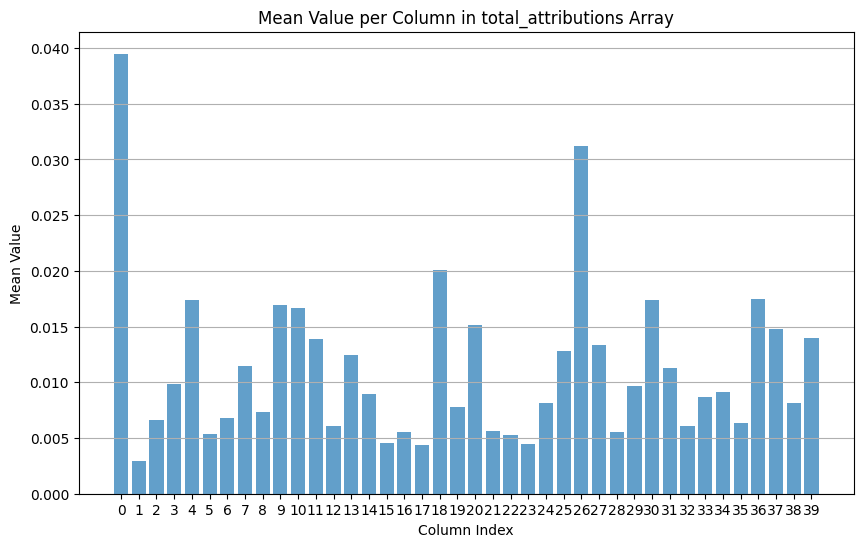

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming total_attributions is your NumPy array
mean_values = np.mean(total_attributions, axis=0)

# Plotting the mean values per column
plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(mean_values)), mean_values, align='center', alpha=0.7)
plt.xlabel('Column Index')
plt.ylabel('Mean Value')
plt.title('Mean Value per Column in total_attributions Array')
plt.xticks(np.arange(len(mean_values)), np.arange(len(mean_values)))
plt.grid(axis='y')
plt.show()


Schatten‑1 norms per component:
  fc1: 6.836, 6.813, 6.543, 7.010, 6.710, 6.720, 6.791, 6.813, 6.862, 6.711, 6.733, 6.781, 6.651, 6.681, 6.805, 6.905, 6.936, 7.005, 6.545, 6.806, 6.648, 6.699, 7.031, 6.676, 6.946, 6.950, 6.640, 6.768, 6.741, 6.788, 6.836, 6.960, 6.588, 6.609, 6.722, 6.853, 6.831, 6.911, 6.809, 7.072
  fc2: 0.504, 0.309, 0.304, 0.334, 0.396, 0.289, 0.342, 0.248, 0.320, 0.346, 0.405, 0.392, 0.315, 0.308, 0.455, 0.291, 0.348, 0.374, 0.287, 0.274, 0.316, 0.386, 0.345, 0.321, 0.415, 0.366, 0.350, 0.349, 0.301, 0.382, 0.341, 0.360, 0.351, 0.282, 0.323, 0.289, 0.419, 0.420, 0.410, 0.849


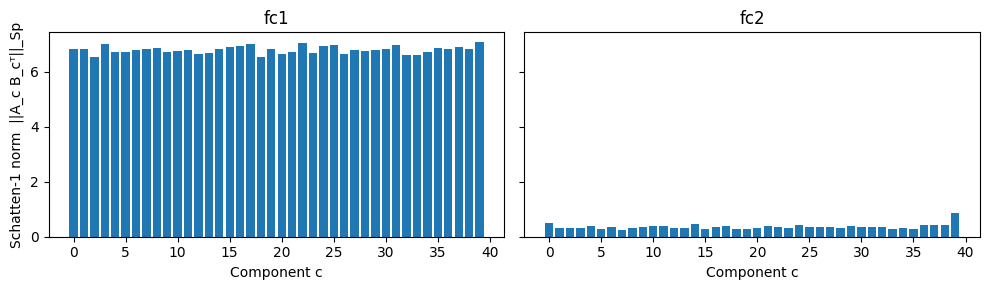

In [13]:
def component_schatten_norms(spd_head: SPDTwoLayerFC, p: float = 2.0):
    norms = {}                                      # {layer: np.array[C]}
    for layer_name in ("fc1", "fc2"):
        layer = getattr(spd_head, layer_name)
        A, B = layer.A, layer.B                     # A:[C,d_in,m], B:[C,m,d_out]
        C = A.size(0)
        comp_norms = torch.zeros(C, device=A.device)
        for c in range(C):
            # full weight slice for this component
            P_c = A[c] @ B[c]                       # shape (d_in, d_out)  rank ≤ m
            s = torch.linalg.svdvals(P_c)           # singular values
            comp_norms[c] = (s.pow(p).sum()) ** (1.0 / p)
        norms[layer_name] = comp_norms.detach().cpu().numpy()
    return norms

schatten_p = 1.0          # pick the p‑norm you care about
schatten = component_schatten_norms(spd_fc, p=schatten_p)

# Pretty print
print(f"\nSchatten‑{schatten_p:g} norms per component:")
for lyr, arr in schatten.items():
    print(f"  {lyr}: " + ", ".join(f"{v:.3f}" for v in arr))

# If you also want a quick visual comparison:
fig, ax = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
for i, lyr in enumerate(("fc1", "fc2")):
    ax[i].bar(np.arange(len(schatten[lyr])), schatten[lyr])
    ax[i].set_title(f"{lyr}")
    ax[i].set_xlabel("Component c")
ax[0].set_ylabel(f"Schatten‑{schatten_p:g} norm  ||A_c B_cᵀ||_Sp")
plt.tight_layout()
plt.show()